# isoRandForest Demo

Demonstrates the use of the isoRandForest implementation of the
iForest (IsolationForest) algorithm by Liu et al [2008].

*Please be aware that the current implementation is meant to be a proof of concept,* **NOT** *a production-ready library*
*In fact, scikit-learn already has a faster and more feature-complete implementation of the algorithm availble. This*
*version is stripped down for the purpopse of exposing the core idea of the algorithm.*

---
We begin by importing necessary libraries for the demo. Note that the only actual dependency for isoRandForest
is NumPy. The others are imported to make plotting more convenient (and more pretty).


**Be sure isoRandForest.py is in the same directory as this notebook before running.**

In [12]:
import numpy as np
import pandas as pd
import ggplot as gg
import isoRandForest as irf

## Simulating some data

Here, we generate a log of simulated user activity. Our system will have two users:
user 0 and user 1. The log will keep track of their login time, session length and of course
the user ID.

User 0 comprises the first 6000 rows. This user's login behavior is as follows:
* Logs in at a *normally distributed* time of day with **mean 14:00** and **standard deviation of 40 minutes**
* Logs in for an *exponentially distributed* amount of time with **average session length of 6 minutes**

User 1 comprises the final 4000 rows. This user's login behavior is as follows:
* Logs in at a *normally distributed* time of day with **mean 08:00** and **standard deviation of 1 hour**
* Logs in for an *exponentially distributed* amount of time with **average session length of 10 minutes**

### Let's make some anomalies

Suppose user 0 is doing something they probably shouldn't be doing during a couple sessions. 
For simplicity, we'll assume those sessions are the first 3 in the data set (being the data was
simulated iid, it really doesn't matter which 3 we pick). So, our nefarious user 0 alters the log
so those sessions show as belonging to user 1. For shame, user 0.

In [22]:
np.random.seed(11111)

example_data = np.zeros([10000, 3])
user1_mask = np.array(range(10000)) < 6000
user2_mask = np.array(range(10000)) >= 6000

example_data[user1_mask, 0] = 50400 + 2400 * np.random.randn(user1_mask.sum())
example_data[user1_mask, 1] = np.random.exponential(360, user1_mask.sum())

example_data[user2_mask, 0] = 28800 + 3600 * np.random.randn(user2_mask.sum())
example_data[user2_mask, 1] = np.random.exponential(600, user2_mask.sum())

example_data[user2_mask, 2] = 1

example_data[[0,1,2],2] = 1

df = pd.DataFrame(example_data)
df.columns = ['login_time', 'session_len', 'user']

#df.to_csv('user_activity_log_demo.csv', index=False)

## Let's Visualize!

Here, we generate a plot of the user behavior. Hopefully, something will stand out to help us find the rows user 0 messed with.

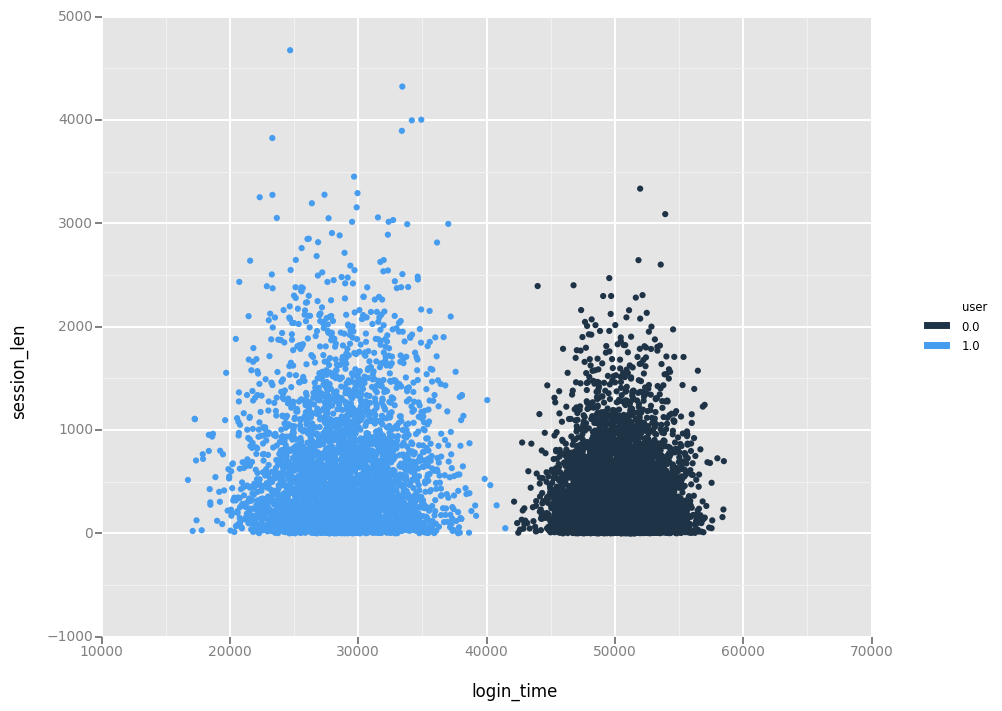

<ggplot: (8793480862981)>

In [23]:
gg.ggplot(gg.aes(x='login_time', y='session_len', color='user'), data=df) + gg.geom_point()

Hmm. It looks like overplotting is keeping us from seeing the altered sessions. You win this round, user 0.
Let's see if we can find user 0's altered sessions using **isoRandForest**.

*Don't worry if it takes a while (~2-4 minutes) to fit the model. The implementation hasn't been optimized yet.*

In [24]:
anom_forest = irf.IsoRandForest(random_seed=12345)

In [25]:
anom_forest.fit(example_data)

Moment of Truth Time. Let's see what the anomaly scores look like for the first few entries in the log file.

In [26]:
anom_forest.anom_scores[0:20]

array([ 0.6882679 ,  0.72863837,  0.67358272,  0.58322427,  0.59136683,
        0.58322427,  0.58322427,  0.58322427,  0.58434844,  0.58502399,
        0.58389852,  0.58322427,  0.58412344,  0.58367368,  0.58322427,
        0.58886684,  0.58412344,  0.58322427,  0.58322427,  0.58322427])

Hey! Look at that! Our first three entries have anomaly scores much higher than the remaining entries.

Before we move forward, let's try fitting just one random tree and seeing what happens (don't worry, this will run almost instantly)

In [27]:
iTree = irf.IsoRandForest.IsoTree(max_depth=20)
iTree.fitTree(example_data)

In [36]:
print "Depth of row  0:   %d\nDepth of row 10:   %d" % (iTree.findDepth(example_data[0,:]), iTree.findDepth(example_data[10,:]))

Depth of row  0:   13
Depth of row 10:   20


What the numbers above mean is that, for this one random tree, it takes 13 random splits of the original data set to isolate the first row, whereas it takes 20 random splits (the maximum allowable depth of a single tree) to isolate the 11th row (actually, the 11th row wasn't quite *isolated* -- we just use the term *isolated* to signify that we've reached a leaf node in the tree).

The anomaly scores above represent the average of all such depths for a point, then normalized to be in the interval (0, 1).

## Let's Visualize (Again)!

Now, let's plot the same user behavior as before, but this time we'll mark all of the points with anomaly scores with a different color.

In [46]:
df['user'] = df['user'].apply(lambda x: str(x))
df['anom'] = '0'
anom_mask = anom_forest.anom_scores > .65
df.loc[anom_mask, 'anom'] = '1'

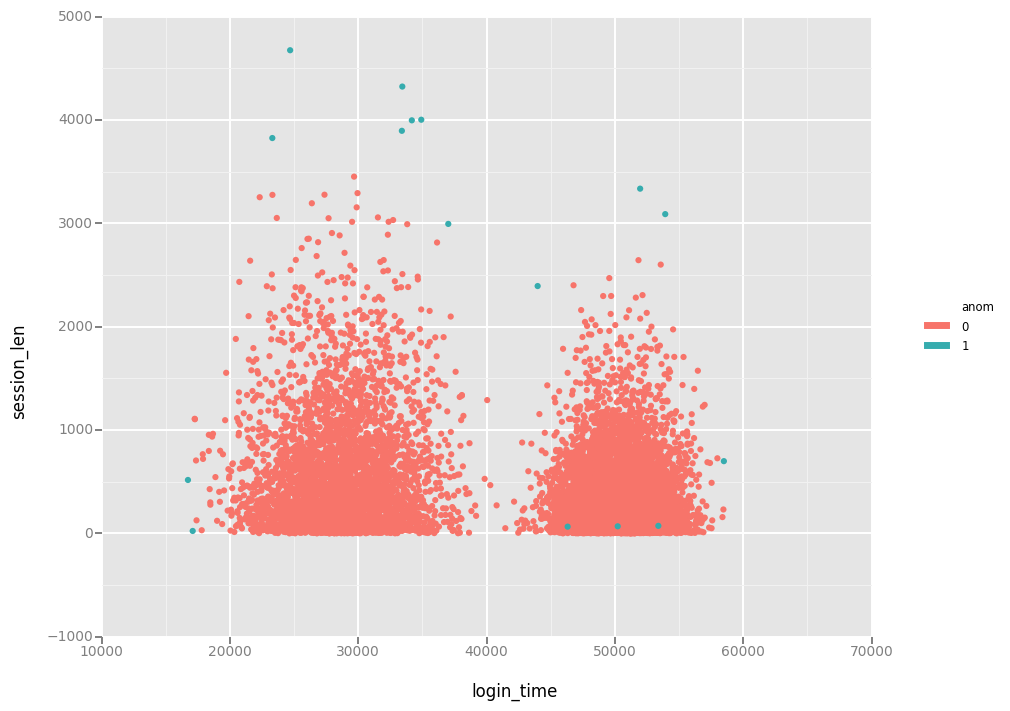

<ggplot: (8793480062865)>


In [47]:
g = gg.ggplot(gg.aes(x='login_time', y='session_len', color='anom'), data=df) +\
    gg.geom_point()
print g

Notice that above, most of our anomalous points are pretty far from the center of either user cluster. However, we have three points that are well inside user 0's cluster. If those points belonged to user 1, they're pretty extreme outliers and definitely worth looking into a little closer.

In [48]:
print df[anom_mask]

        login_time  session_len user anom
0     50214.718405    68.573049  1.0    1
1     53380.327149    73.086721  1.0    1
2     46313.149066    65.263896  1.0    1
1213  51962.226440  3336.264575  0.0    1
1875  53916.886757  3089.862907  0.0    1
2881  43975.494486  2393.704898  0.0    1
3124  58486.333973   699.153837  0.0    1
6299  16725.989200   517.032093  1.0    1
6698  23300.513815  3826.072998  1.0    1
7143  33394.775178  3896.060456  1.0    1
7346  17095.484340    23.531255  1.0    1
7803  24688.154119  4675.759398  1.0    1
8987  34906.963670  4003.312572  1.0    1
9007  37011.373450  2995.062385  1.0    1
9258  34171.003825  3997.486539  1.0    1
9479  33429.401435  4324.306054  1.0    1


Look at that. Our first three rows have login times that are way too late in the day for user 1. You were a worthy adversary, user 0, but not worthy enough to best the iForest algorithm.